<h1 align="center"> <span style="font-size: 20px;"> Proyecto Final Grupo Nº 7 </span> <br>
    <align="center"> <span style="font-size: 15px;">  Proyecto Yelp & Google Maps - Reviewa y Recomendaciones</span><br>         
<align="center"> <span style="font-size: 15px;">@utores:  Javier Castro, Luca Ramallo, Luis Ramírez, Lesmen García.</span> <br>
  <a href="https://github.com/lesmengp/Proyecto-Final-Grupo-07.git">GitHub: <span style="font-size: 20px;">Proyecto Yelp & Google Maps</span></a> 
</h1>

In [1]:
!pip install google.cloud

In [2]:
!pip install missingno

In [3]:
!pip install folium

In [4]:
!pip install gcsfs --upgrade

In [5]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
import json
import os
import io
import gcsfs
from datetime import datetime
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import gcsfs

### 1) Importando Yelp Business

In [6]:
### Valida Primer Dataframe
# Ruta completa en Cloud Storage
ruta_cloud_storage = "gs://gmy/dataset/business/business.parquet"

# Lee el archivo Parquet directamente en un DataFrame de pandas
df_business = pd.read_parquet(ruta_cloud_storage, storage_options={"project": "Proyecto Final - Henry"})

In [7]:
df_business.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471658,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,AZ,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
3,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",Brentwood,PA,63144,38.627695,-90.340465,2.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Sporting Goods, Fashion, Shoe Stores, Shopping...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ..."
4,qkRM_2X51Yqxk3btlwAQIg,Temple Beth-El,400 Pasadena Ave S,St. Petersburg,PA,33707,27.766590,-82.732983,3.5,5,1,None,"Synagogues, Religious Organizations","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ..."


In [8]:
listado_columnas_desechables = ['postal_code','is_open','hours']

df_business.drop(columns=listado_columnas_desechables, inplace=True)

In [9]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145216 entries, 0 to 145215
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   145216 non-null  object 
 1   name          145216 non-null  object 
 2   address       145216 non-null  object 
 3   city          145216 non-null  object 
 4   state         145216 non-null  object 
 5   latitude      145216 non-null  float64
 6   longitude     145216 non-null  float64
 7   stars         145216 non-null  float64
 8   review_count  145216 non-null  int64  
 9   attributes    132343 non-null  object 
 10  categories    145114 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 12.2+ MB


<Axes: >

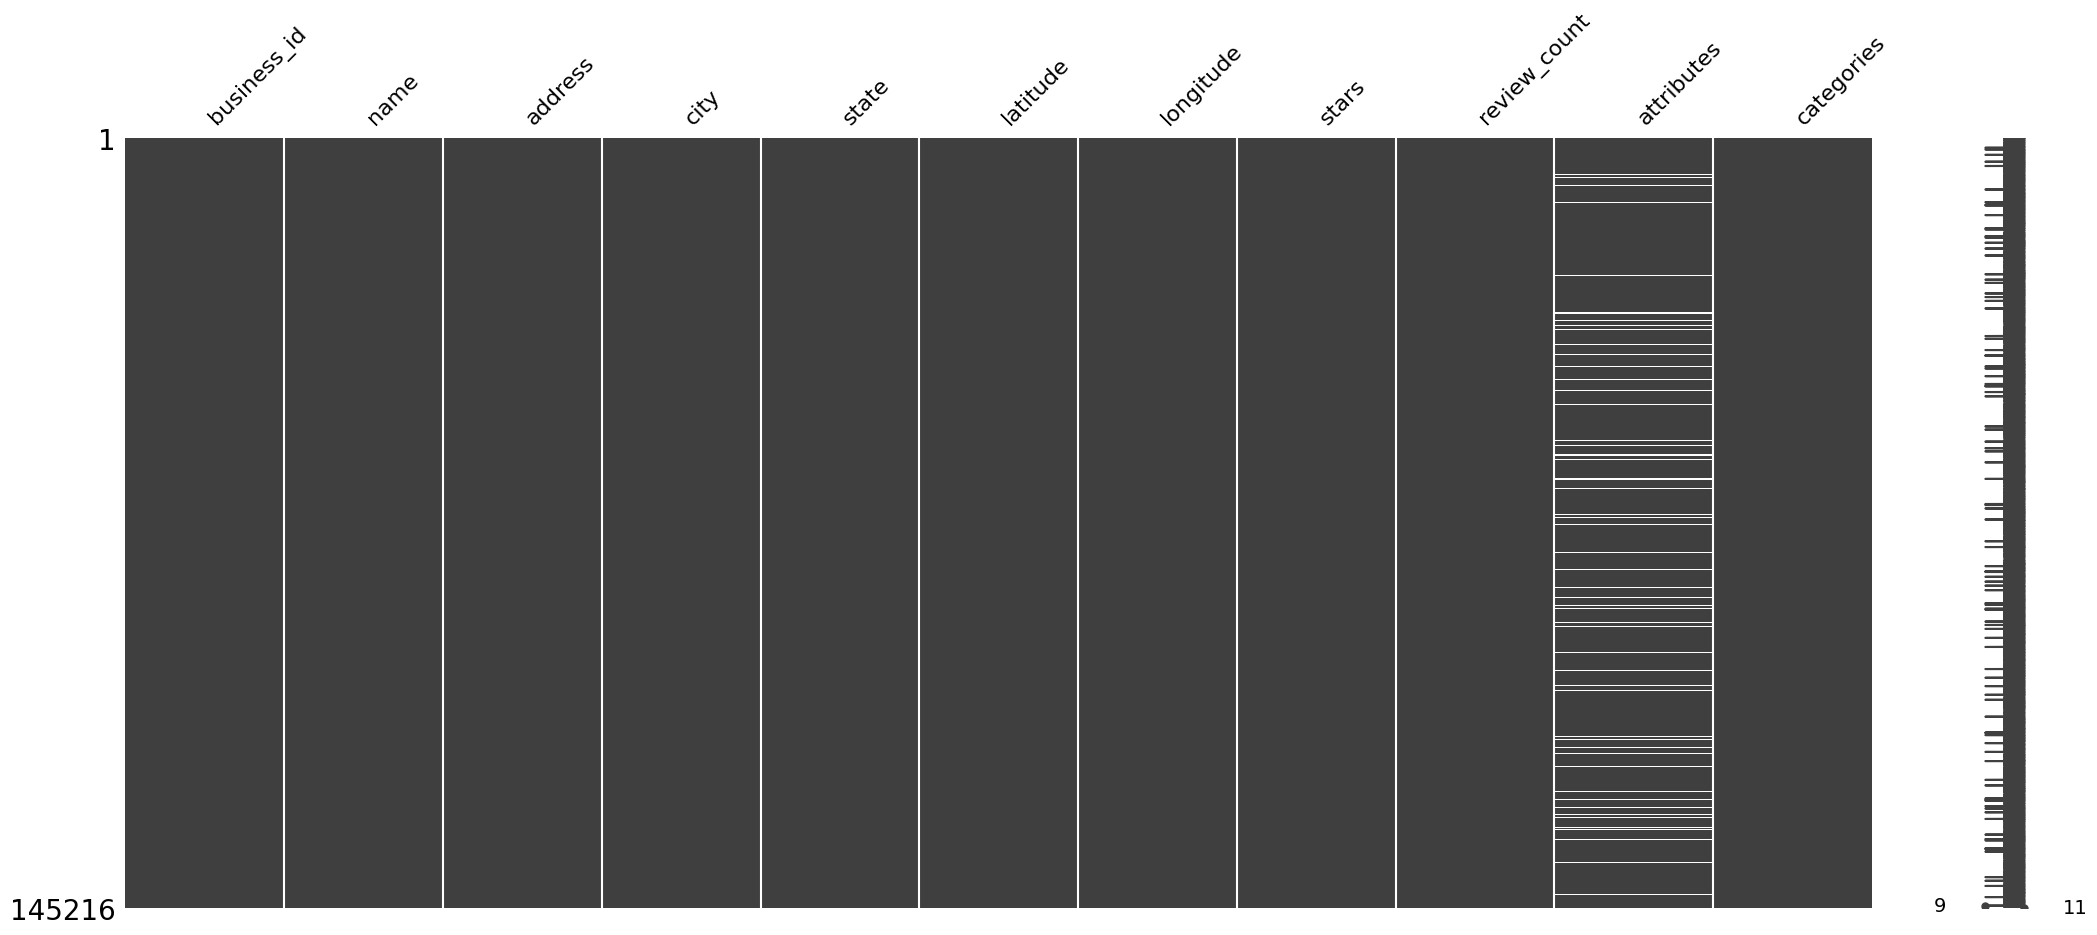

In [10]:
msno.matrix(df_business)

### ___________________________________________________________________________________________________________________________________________________________________________

# Estudio de df_business:

In [11]:
df_business.head(5)

,business_id,name,address,city,state,latitude,longitude,stars,review_count,attributes,categories
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,40.338183,-75.471658,4.5,13,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food"
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,AZ,36.269593,-87.058943,2.0,6,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea..."
3,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",Brentwood,PA,38.627695,-90.340465,2.5,13,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Sporting Goods, Fashion, Shoe Stores, Shopping..."
4,qkRM_2X51Yqxk3btlwAQIg,Temple Beth-El,400 Pasadena Ave S,St. Petersburg,PA,27.766590,-82.732983,3.5,5,None,"Synagogues, Religious Organizations"


In [12]:
df_business.describe()

,latitude,longitude,stars,review_count
count,145216.000000,145216.000000,145216.000000,145216.000000
mean,36.697206,-89.206871,3.578821,45.885584
std,5.893913,14.805320,0.964639,122.989570
min,27.555127,-120.095137,1.000000,5.000000
25%,32.186963,-90.347151,3.000000,8.000000
50%,38.782080,-86.115672,3.500000,15.000000
75%,39.954418,-75.412598,4.500000,38.000000
max,53.651838,-73.200457,5.000000,7568.000000


In [13]:
# el centroide de las coordenadas parece estar OK segun google maps,stars y review count tmb parecen estar bien.

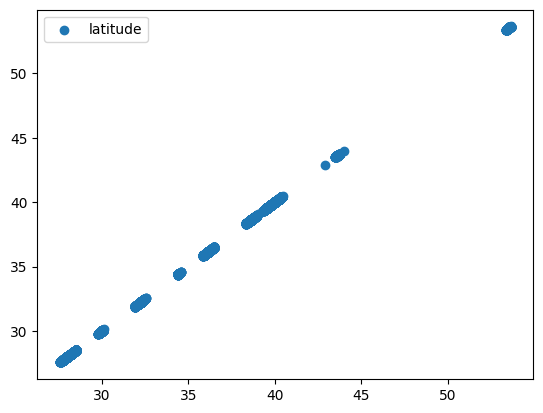

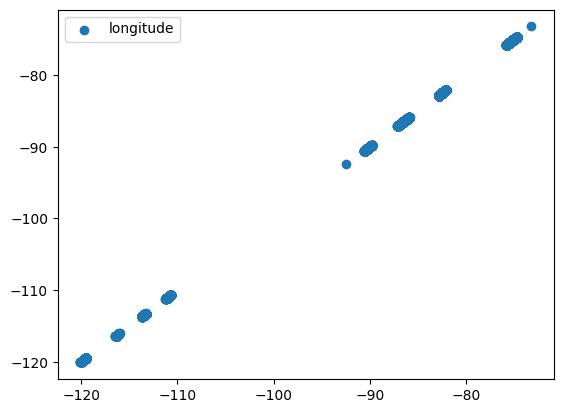

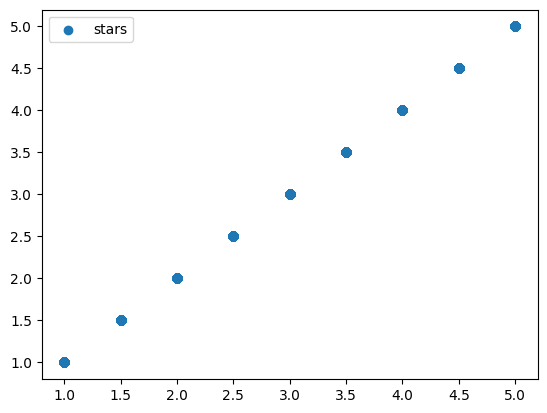

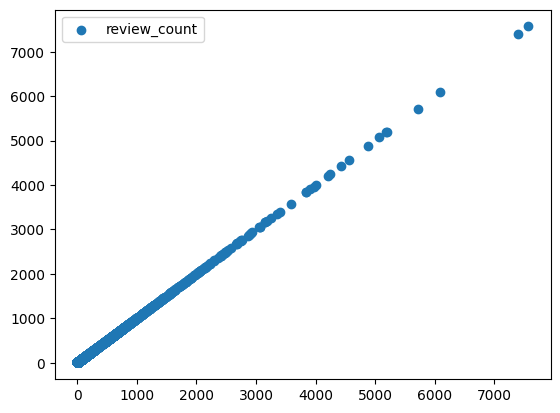

In [14]:
# Obtiene las columnas numéricas del DataFrame
numerical_columns = df_business.select_dtypes('number')

# Crea una figura
fig = plt.figure()

# Itera sobre las columnas numéricas y grafica un scatterplot para cada columna
for column in numerical_columns:
    plt.scatter(df_business[column], df_business[column], label=column)

    # Agrega una leyenda a la figura
    plt.legend()

    # Muestra la figura
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


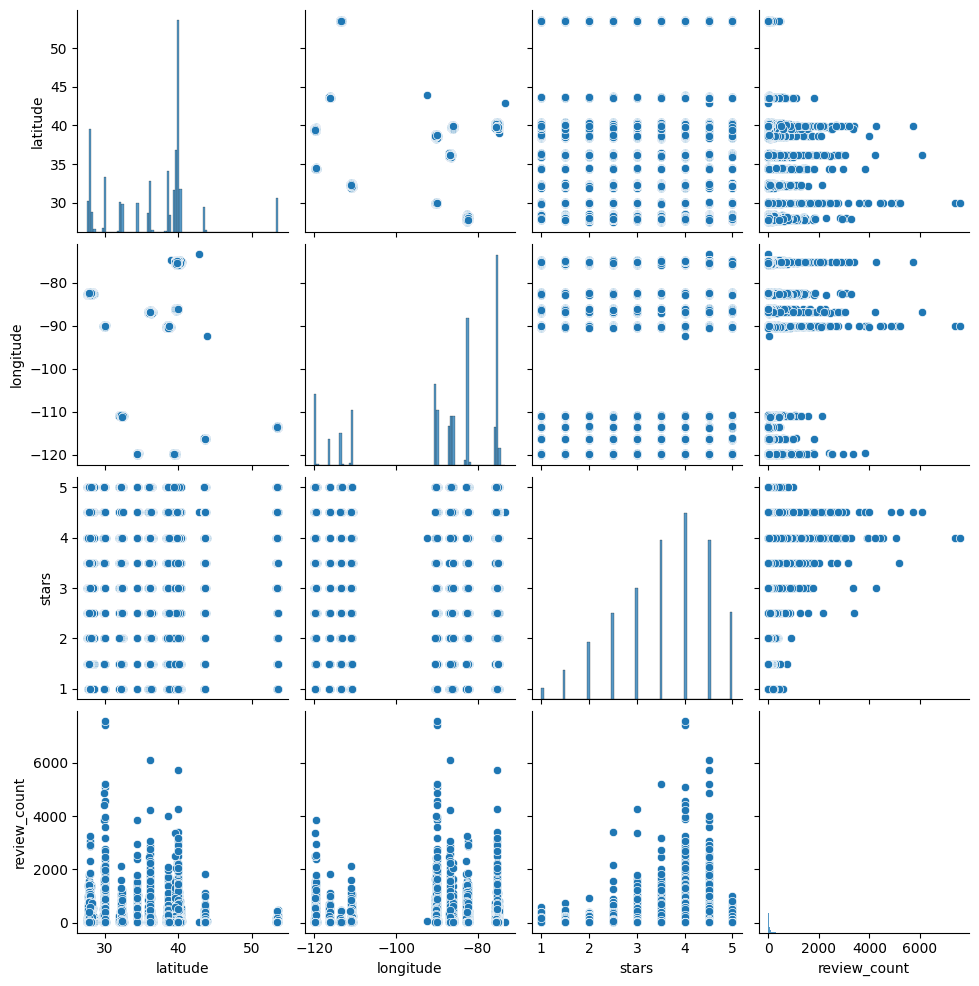

In [15]:
sns.pairplot(df_business)

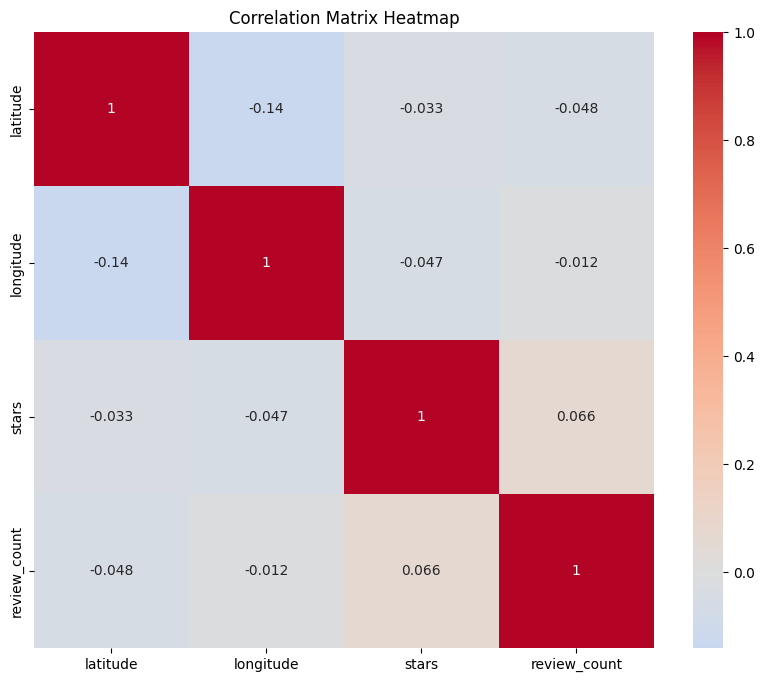

In [16]:
# Calcular la matriz de correlación
correlation_matrix = numerical_columns.corr()

# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

# _____________________________________________________________________________________________________________________________________________________________________________________

# Guardar dataframe:

In [17]:
### Guardar Dataset Final de TIP

# Ruta completa en Cloud Storage para guardar el archivo CSV
ruta_cloud_storage_csv = "gs://gmy/etl/yelp_business.csv"

# Guarda el DataFrame en formato CSV en Cloud Storage
df_business.to_csv(ruta_cloud_storage_csv, index=False)

In [18]:
### Guardar Dataset Final de TIP

# Ruta completa en Cloud Storage para guardar el archivo CSV
ruta_cloud_storage_csv = "gs://gmy/etl/yelp_business.parquet"

# Guarda el DataFrame en formato CSV en Cloud Storage
df_business.to_parquet(ruta_cloud_storage_csv, index=False)